[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


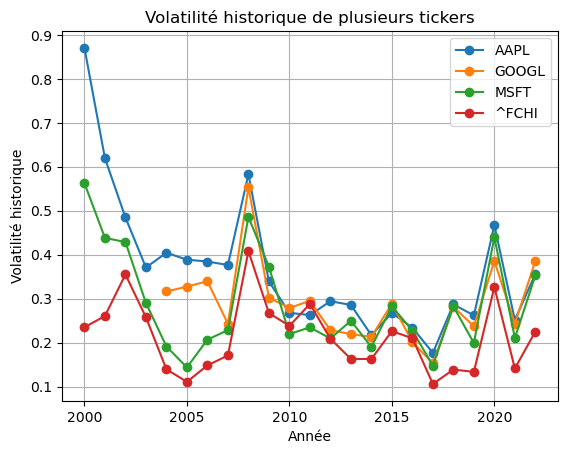

In [38]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Fonction pour calculer la volatilité historique
def calcul_vol(ticker, debut, fin): 
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return []

        returns = data['Close'].pct_change().dropna()

        # Liste pour stocker la volatilité pour chaque année
        volatilite_annuelle = []

        # Calculer la volatilité pour chaque année
        for annee in range(int(debut[:4]), int(fin[:4])):
            returns_annee = returns[returns.index.year == annee]
            volatilite = np.sqrt(len(returns_annee)) * returns_annee.std()
            volatilite_annuelle.append(volatilite)

        return volatilite_annuelle
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return []

# Dates de début et de fin
debut = "2000-01-01"
fin = "2023-01-01"

# Liste des tickers
tickers = ["AAPL", "GOOGL", "MSFT", "^FCHI"]

# Liste pour stocker les années
A = np.array(list(range(int(debut[:4]), int(fin[:4]))))

# Liste pour stocker les volatilités
V = []

# Calculer la volatilité pour chaque ticker
for ticker in tickers:
    volatilite = np.array(calcul_vol(ticker, debut, fin))
    if len(volatilite) == len(A):
        V.append(volatilite)
    else:
        print(f"La volatilité n'a pas pu être calculée pour le ticker {ticker}. Vérifiez les données.")

# Tracé des données
if len(V) > 0:
    for i, ticker in enumerate(tickers):
        if i < len(V):
            plt.plot(A, V[i], marker='o', linestyle='-', label=ticker)

    plt.title('Volatilité historique de plusieurs tickers')
    plt.xlabel('Année')
    plt.ylabel('Volatilité historique')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Aucune donnée de volatilité disponible pour les tickers spécifiés.")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
            FEDFUNDS
DATE                
2007-01-01      5.25
2007-02-01      5.26
2007-03-01      5.26
2007-04-01      5.25
2007-05-01      5.25
            FEDFUNDS
DATE                
2007-01-01      5.25
2007-02-01      5.26
2007-03-01      5.26
2007-04-01      5.25
2007-05-01      5.25


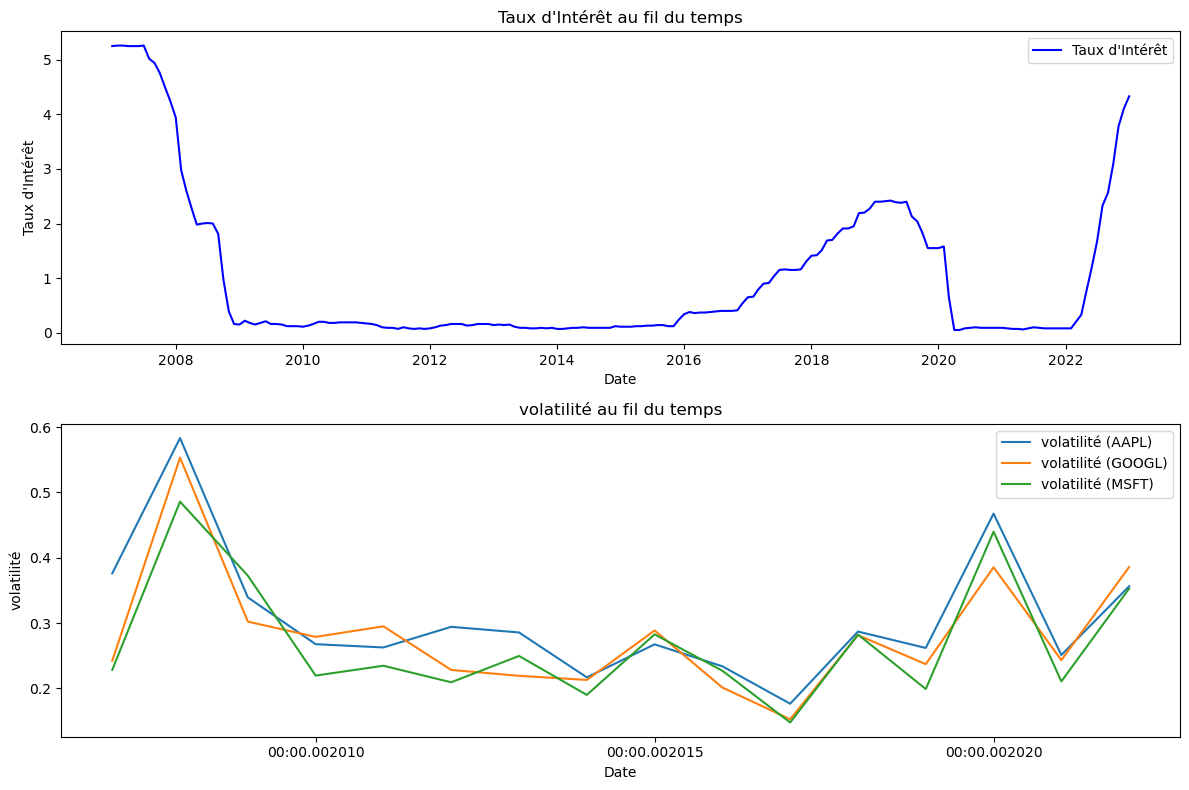

In [37]:
!pip install matplotlib 
!pip install yfinance
!pip install --upgrade nbdime
import pandas_datareader as pdr
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Définir les bornes chronologiques et les tickers utilités
debut = "2007-01-01"
fin = "2023-01-01"
tickers = ["AAPL", "GOOGL", "MSFT"]

# Liste pour stocker les années et liste pour les volatilités
A = np.array(list(range(int(debut[:4]), int(fin[:4]))))
V = []

# Fonction permettant de calculer la volatilité historique depuis yfinance
def calcul_vol(ticker, debut, fin):
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return []

        returns = data['Close'].pct_change().dropna()

        # Liste pour stocker la volatilité pour chaque année
        vol_annuelle = []

        # Calculer la volatilité pour chaque année
        for annee in range(int(debut[:4]), int(fin[:4])):
            returns_annee = returns[returns.index.year == annee]
            volatilite = np.sqrt(len(returns_annee)) * returns_annee.std()
            vol_annuelle.append(volatilite)

        return vol_annuelle
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return []

# Calcul volatilité pour chaque ticker
for ticker in tickers:
    volatilite = np.array(calcul_vol(ticker, debut, fin))
    if len(volatilite) == len(A):
        V.append(volatilite)

# Créer un DataFrame avec les données de volatilité
data_volatilite = pd.DataFrame(data=np.array(V).T, index=A, columns=tickers)

# Charger les données de taux d'intérêt des fonds fédéraux US
try:
    tx_fed_funds = pdr.get_data_fred('FEDFUNDS', start=debut, end=fin)
    print(tx_fed_funds.head())
    # Sauvegarder les données dans un fichier CSV
    tx_fed_funds.to_csv('tx_fed_funds.csv')
except Exception as e:
    print(f"Erreur lors de la récupération des données de taux d'intérêt : {e}")

# Charger les données de taux d'intérêt des fonds fédéraux US depuis le fichier CSV
try:
    tx_fed_funds = pd.read_csv('tx_fed_funds.csv', index_col='DATE', parse_dates=True)
    print(tx_fed_funds.head())
except Exception as e:
    print(f"Erreur lors de la lecture du fichier CSV des taux d'intérêt : {e}")

# Fusionner les données de taux d'intérêt et de volatilité
merged_data = pd.merge(tx_fed_funds, data_volatilite, how='outer', left_index=True, right_index=True)

# Tracé des deux séries temporelles
plt.figure(figsize=(12, 8))

# Tracé des taux d'intérêt
plt.subplot(2, 1, 1)
plt.plot(merged_data['FEDFUNDS'], label='Taux d\'Intérêt', color='blue')
plt.title('Taux d\'Intérêt au fil du temps')
plt.xlabel('Date')
plt.ylabel('Taux d\'Intérêt')
plt.legend()

# Tracé de la volatilité pour chaque ticker
plt.subplot(2, 1, 2)
for ticker in tickers:
    plt.plot(merged_data[ticker], label=f'volatilité ({ticker})')
plt.title('volatilité au fil du temps')
plt.xlabel('Date')
plt.ylabel('volatilité')
plt.legend()

plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


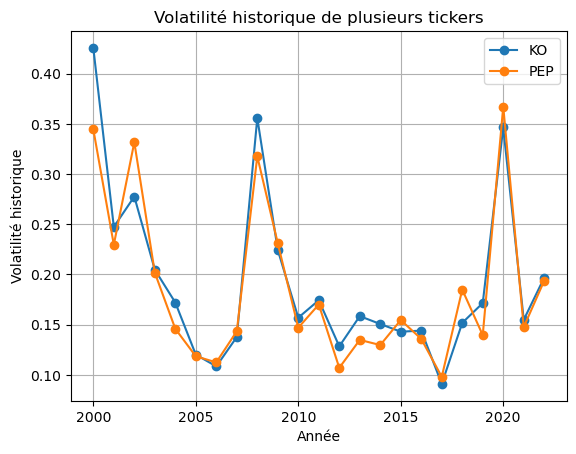

In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Fonction pour calculer la volatilité historique
def calcul_vol(ticker, debut, fin): 
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return []

        returns = data['Close'].pct_change().dropna()

        # Liste pour stocker la volatilité pour chaque année
        volatilite_annuelle = []

        # Calculer la volatilité pour chaque année
        for annee in range(int(debut[:4]), int(fin[:4])):
            returns_annee = returns[returns.index.year == annee]
            volatilite = np.sqrt(len(returns_annee)) * returns_annee.std()
            volatilite_annuelle.append(volatilite)

        return volatilite_annuelle
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return []

# Dates de début et de fin
debut = "2000-01-01"
fin = "2023-01-01"

# Liste des tickers
tickers = ["KO", "PEP"]

# Liste pour stocker les années
A = np.array(list(range(int(debut[:4]), int(fin[:4]))))

# Liste pour stocker les volatilités
V = []

# Calculer la volatilité pour chaque ticker
for ticker in tickers:
    volatilite = np.array(calcul_vol(ticker, debut, fin))
    if len(volatilite) == len(A):
        V.append(volatilite)
    else:
        print(f"La volatilité n'a pas pu être calculée pour le ticker {ticker}. Vérifiez les données.")

# Tracé des données
if len(V) > 0:
    for i, ticker in enumerate(tickers):
        if i < len(V):
            plt.plot(A, V[i], marker='o', linestyle='-', label=ticker)

    plt.title('Volatilité historique de plusieurs tickers')
    plt.xlabel('Année')
    plt.ylabel('Volatilité historique')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Aucune donnée de volatilité disponible pour les tickers spécifiés.")


In [49]:
!pip install yfinance pandas numpy matplotlib py_vollib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from py_vollib.black_scholes import black_scholes

# Fonction pour calculer la volatilité historique
def calcul_vol(ticker, debut, fin):
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return pd.Series([])

        returns = data['Close'].pct_change().dropna()

        # Calculer la volatilité pour chaque année
        vol_annuelle = returns.groupby(returns.index.year).std()

        return vol_annuelle
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return pd.Series([])

# Fonction pour calculer le prix de l'option d'achat avec le modèle de Black-Scholes
def calcul_prix_option(S, K, T, r, sigma):
    return black_scholes('c', S, K, T, r, sigma, 0)

# Paramètres
debut = "2022-01-01"
fin = "2023-01-01"
ticker = "AAPL"
strike = 150  # Prix d'exercice de l'option
maturity = 1  # Maturité de l'option en années
taux_sans_risque = 0  # Taux d'intérêt sans risque (dans cet exemple, le taux est fixé à zéro)

# Calculer la volatilité historique
volatilite_annuelle = calcul_vol(ticker, debut, fin)

# Si la volatilité est disponible, procéder au calcul des prix des options
if not volatilite_annuelle.empty:
    # Générer les dates pour lesquelles nous voulons calculer les prix des options
    dates = pd.date_range(debut, fin, freq='D')

    # Calculer le prix de l'option pour chaque jour de l'année
   # Calculer le prix de l'option pour chaque jour de l'année
prix_options = [
    calcul_prix_option(data['Close'].iloc[-1], strike, maturity, taux_sans_risque, volatilite_annuelle[date.year])
    for date in dates
]



    # Tracer l'évolution du prix de l'option et de la volatilité
fig, ax1 = plt.subplots(figsize=(12, 6))

# Tracer le prix de l'option
ax1.plot(dates, prix_options, label='Prix de l\'option', color='tab:red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Prix de l\'option', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')


    # Tracer l'évolution de la volatilité
ax2 = ax1.twinx()
ax2.plot(volatilite_annuelle.index, volatilite_annuelle, label='Volatilité', color='tab:blue')
ax2.set_ylabel('Volatilité', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

if i < len(V):
    plt.plot(A, V[i], marker='o', linestyle='-', label=ticker)

plt.title('Volatilité historique de plusieurs tickers')
plt.xlabel('Année')
plt.ylabel('Volatilité historique')
plt.legend()
plt.grid(True)
plt.show()

    else:
print("La volatilité n'est pas disponible.")


IndentationError: unexpected indent (3255146023.py, line 84)

In [54]:
!pip install yfinance pandas numpy matplotlib py_vollib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from py_vollib.black_scholes import black_scholes

# Fonction pour calculer la volatilité historique
def calcul_vol(ticker, debut, fin):
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return pd.Series([])

        returns = data['Close'].pct_change().dropna()

        # Calculer la volatilité pour chaque année
        vol_annuelle = returns.groupby(returns.index.year).std()

        return pd.Series(vol_annuelle)
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return pd.Series([])


# Fonction pour calculer le prix de l'option d'achat avec le modèle de Black-Scholes
def calcul_prix_option(S, K, T, r, sigma):
    return black_scholes('c', S, K, T, r, sigma)


# Paramètres
debut = "2022-01-01"
fin = "2023-01-01"
ticker = "AAPL"
strike = 150  # Prix d'exercice de l'option
maturity = 1  # Maturité de l'option en années
taux_sans_risque = 0  # Taux d'intérêt sans risque (dans cet exemple, le taux est fixé à zéro)

# Calculer la volatilité historique
volatilite_annuelle = calcul_vol(ticker, debut, fin)

# Si la volatilité est disponible, procéder au calcul des prix des options
if not volatilite_annuelle.empty:
    # Générer les dates pour lesquelles nous voulons calculer les prix des options
    dates = pd.date_range(debut, fin, freq='D')

    # Calculer le prix de l'option pour chaque jour de l'année
    prix_options = [
        calcul_prix_option(data['Close'].iloc[-1], strike, maturity, taux_sans_risque, volatilite_annuelle[date.year])
        for date in dates
    ]


    # Tracer l'évolution du prix de l'option et de la volatilité
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Tracer le prix de l'option
    ax1.plot(dates, prix_options, label='Prix de l\'option', color='tab:red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Prix de l\'option', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.legend(loc='upper left')

    # Tracer l'évolution de la volatilité
    ax2 = ax1.twinx()
    ax2.plot(volatilite_annuelle.index, volatilite_annuelle, label='Volatilité', color='tab:blue')
    ax2.set_ylabel('Volatilité', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.legend(loc='upper right')

    plt.title('Évolution du prix de l\'option et de la volatilité')
    plt.show()

else:
    print("La volatilité n'est pas disponible.")


[*********************100%%**********************]  1 of 1 completed


TypeError: cannot convert the series to <class 'float'>

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


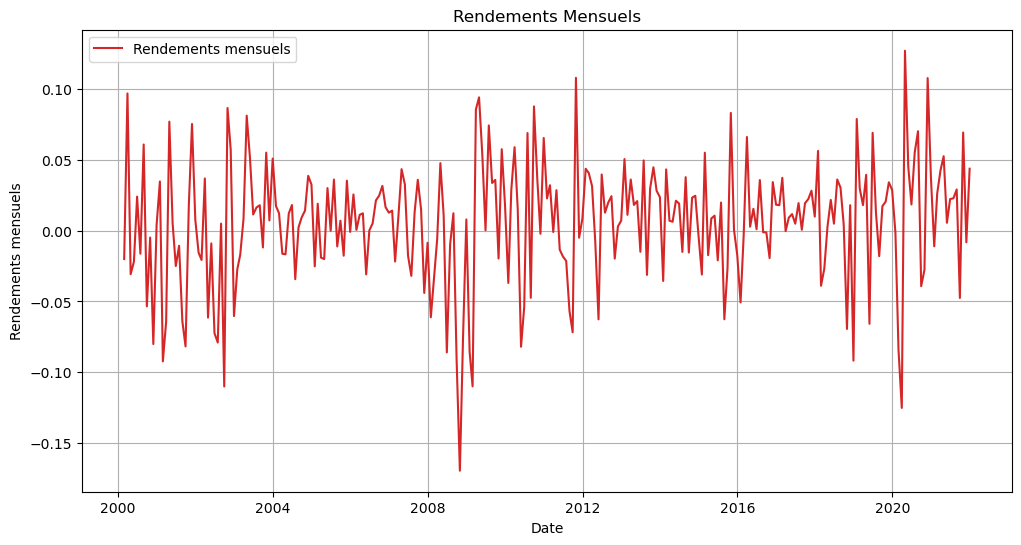

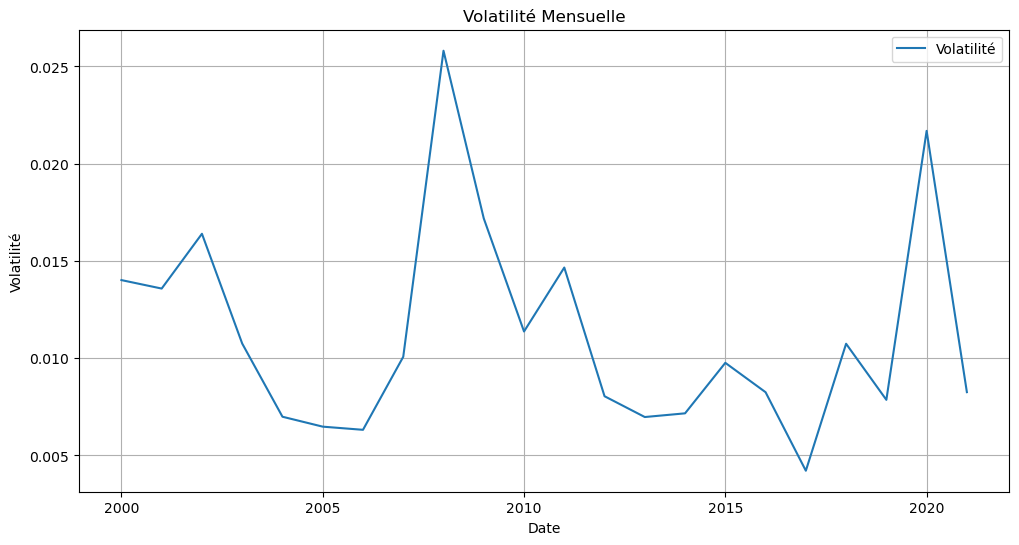

In [57]:
!pip install yfinance pandas numpy matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from py_vollib.black_scholes import black_scholes

# Fonction pour calculer la volatilité historique
def calcul_vol(ticker, debut, fin):
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return pd.Series([])

        returns = data['Close'].pct_change().dropna()

        # Calculer la volatilité pour chaque année
        vol_annuelle = returns.groupby(returns.index.year).std()

        return pd.Series(vol_annuelle)
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return pd.Series([])
# Fonction pour calculer les rendements mensuels
def calcul_rendements_mensuels(ticker, debut, fin):
    data = yf.download(ticker, start=debut, end=fin, interval="1d")
    rendements_mensuels = data['Close'].resample('M').ffill().pct_change().dropna()
    return rendements_mensuels

# Télécharger les données pour un actif donné (par exemple, l'indice S&P 500)
ticker = "^GSPC"
debut = "2000-01-01"
fin = "2022-01-01"

volatilite = calcul_vol(ticker, debut, fin)
rendements_mensuels = calcul_rendements_mensuels(ticker, debut, fin)

# Tracer les rendements mensuels
plt.figure(figsize=(12, 6))
plt.plot(rendements_mensuels.index, rendements_mensuels, label='Rendements mensuels', color='tab:red')
plt.title('Rendements Mensuels')
plt.xlabel('Date')
plt.ylabel('Rendements mensuels')
plt.legend()
plt.grid(True)
plt.show()

# Tracer la volatilité
plt.figure(figsize=(12, 6))
plt.plot(volatilite.index, volatilite, label='Volatilité', color='tab:blue')
plt.title('Volatilité Mensuelle')
plt.xlabel('Date')
plt.ylabel('Volatilité')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed


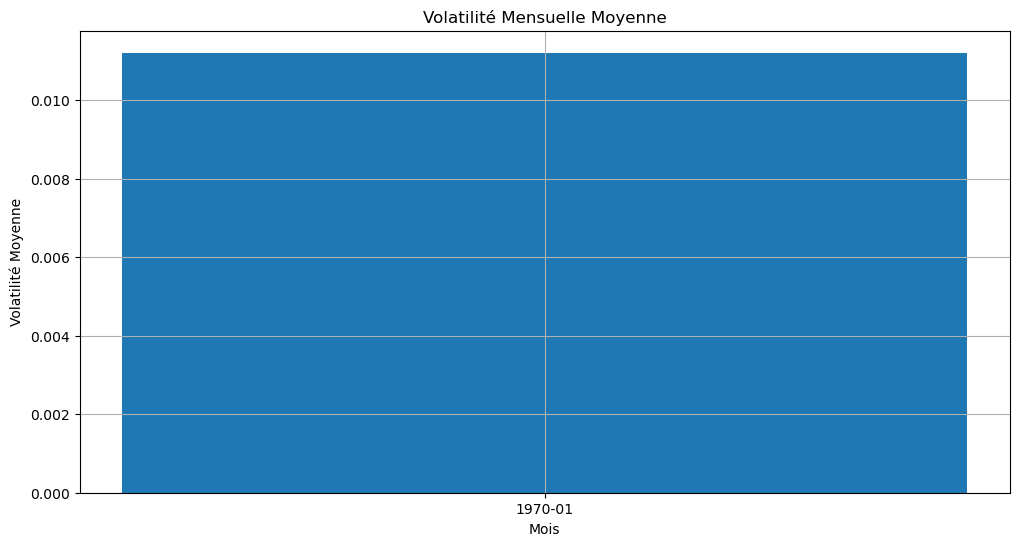

In [60]:
!pip install yfinance pandas numpy matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer la volatilité historique
def calcul_vol(ticker, debut, fin):
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return pd.Series([])

        returns = data['Close'].pct_change().dropna()

        # Calculer la volatilité pour chaque année
        vol_annuelle = returns.groupby(returns.index.year).std()

        return pd.Series(vol_annuelle)
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return pd.Series([])

# Fonction pour calculer la volatilité mensuelle moyenne
def calcul_volatilite_mensuelle(ticker, debut, fin):
    volatilite = calcul_vol(ticker, debut, fin)
    volatilite.index = pd.to_datetime(volatilite.index)  # Ensure datetime index
    volatilite_mensuelle = volatilite.groupby(volatilite.index.strftime('%Y-%m')).mean()
    return volatilite_mensuelle



# Télécharger les données pour un actif donné (par exemple, l'indice S&P 500)
ticker = "^GSPC"
debut = "2000-01-01"
fin = "2022-01-01"

volatilite_mensuelle = calcul_volatilite_mensuelle(ticker, debut, fin)

# Tracer la volatilité mensuelle moyenne
plt.figure(figsize=(12, 6))
plt.bar(volatilite_mensuelle.index, volatilite_mensuelle, color='tab:blue')
plt.title('Volatilité Mensuelle Moyenne')
plt.xlabel('Mois')
plt.ylabel('Volatilité Moyenne')
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed


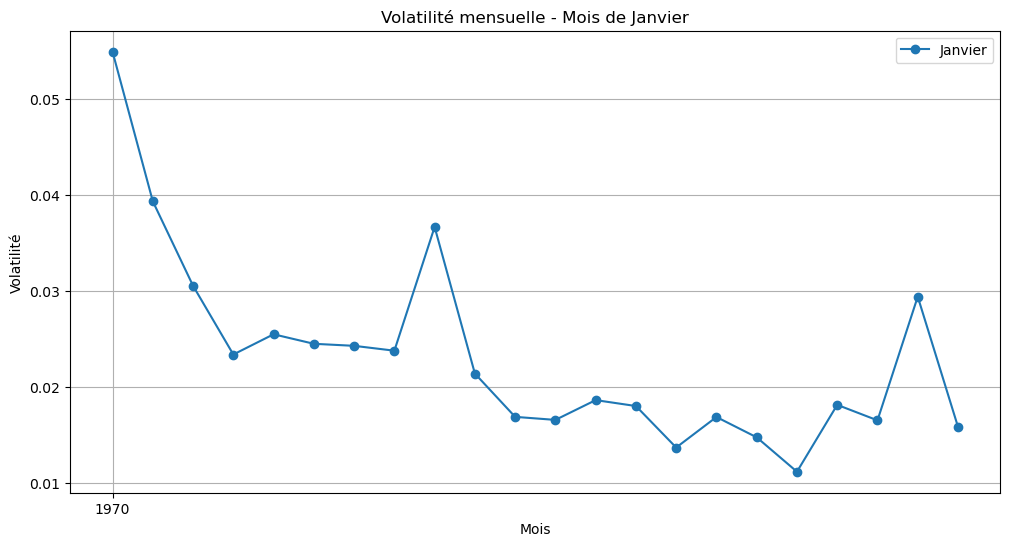

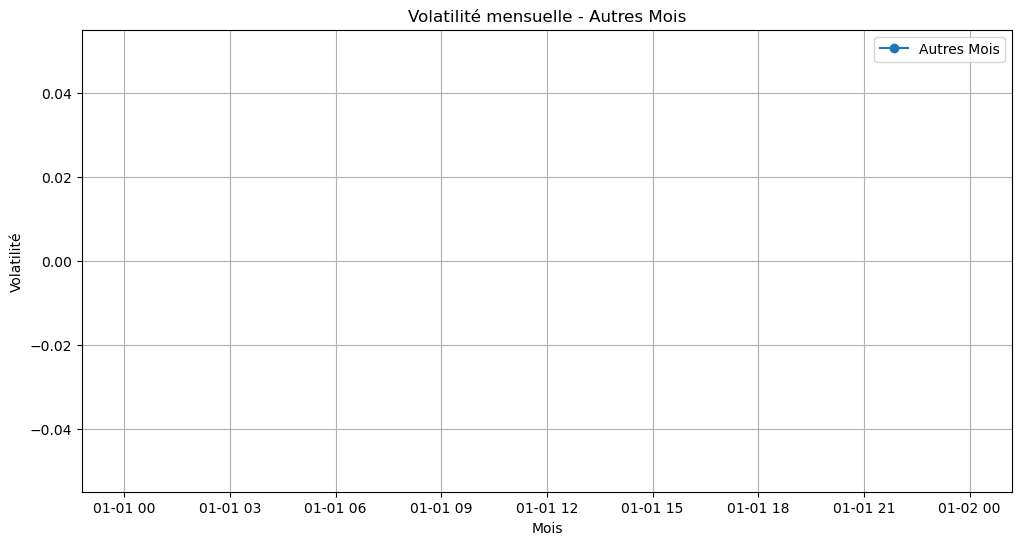

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour calculer la volatilité mensuelle
def calcul_volatilite_mensuelle(ticker, debut, fin):
    volatilite = calcul_vol(ticker, debut, fin)
    volatilite.index = pd.to_datetime(volatilite.index)  # Ensure datetime index

    # Filtrer les données pour les mois de janvier
    volatilite_janvier = volatilite[volatilite.index.month == 1]

    # Filtrer les données pour les autres mois de l'année
    volatilite_autres_mois = volatilite[volatilite.index.month != 1]

    return volatilite_janvier, volatilite_autres_mois

# Paramètres
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculer la volatilité mensuelle
volatilite_janvier, volatilite_autres_mois = calcul_volatilite_mensuelle(ticker, debut, fin)

# Tracer la volatilité mensuelle pour les mois de janvier
plt.figure(figsize=(12, 6))
plt.plot(volatilite_janvier, marker='o', linestyle='-', label='Janvier')
plt.title('Volatilité mensuelle - Mois de Janvier')
plt.xlabel('Mois')
plt.ylabel('Volatilité')
plt.legend()
plt.grid(True)
plt.show()

# Tracer la volatilité mensuelle pour les autres mois de l'année
plt.figure(figsize=(12, 6))
plt.plot(volatilite_autres_mois, marker='o', linestyle='-', label='Autres Mois')
plt.title('Volatilité mensuelle - Autres Mois')
plt.xlabel('Mois')
plt.ylabel('Volatilité')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed


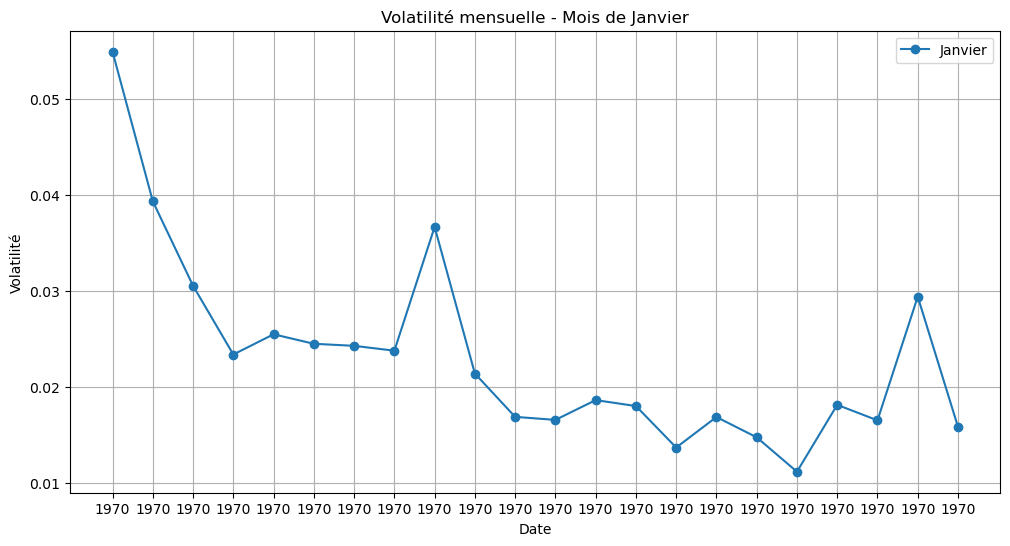

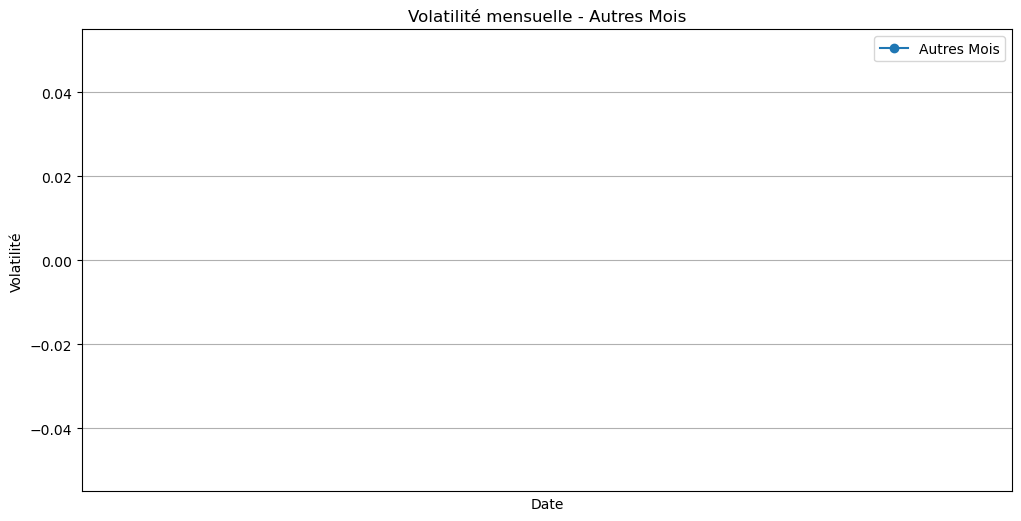

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour calculer la volatilité mensuelle
def calcul_volatilite_mensuelle(ticker, debut, fin):
    volatilite = calcul_vol(ticker, debut, fin)
    volatilite.index = pd.to_datetime(volatilite.index)  # Ensure datetime index

    # Filtrer les données pour les mois de janvier
    volatilite_janvier = volatilite[volatilite.index.month == 1]

    # Filtrer les données pour les autres mois de l'année
    volatilite_autres_mois = volatilite[volatilite.index.month != 1]

    return volatilite_janvier, volatilite_autres_mois

# Paramètres
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculer la volatilité mensuelle
volatilite_janvier, volatilite_autres_mois = calcul_volatilite_mensuelle(ticker, debut, fin)

# Tracer la volatilité mensuelle pour les mois de janvier
plt.figure(figsize=(12, 6))
plt.plot(volatilite_janvier.index, volatilite_janvier, marker='o', linestyle='-', label='Janvier')
plt.title('Volatilité mensuelle - Mois de Janvier')
plt.xlabel('Date')
plt.ylabel('Volatilité')
plt.legend()
plt.grid(True)
plt.xticks(volatilite_janvier.index, [str(date.year) for date in volatilite_janvier.index])
plt.show()

# Tracer la volatilité mensuelle pour les autres mois de l'année
plt.figure(figsize=(12, 6))
plt.plot(volatilite_autres_mois.index, volatilite_autres_mois, marker='o', linestyle='-', label='Autres Mois')
plt.title('Volatilité mensuelle - Autres Mois')
plt.xlabel('Date')
plt.ylabel('Volatilité')
plt.legend()
plt.grid(True)
plt.xticks(volatilite_autres_mois.index, [str(date.year) for date in volatilite_autres_mois.index])
plt.show()


[*********************100%%**********************]  1 of 1 completed


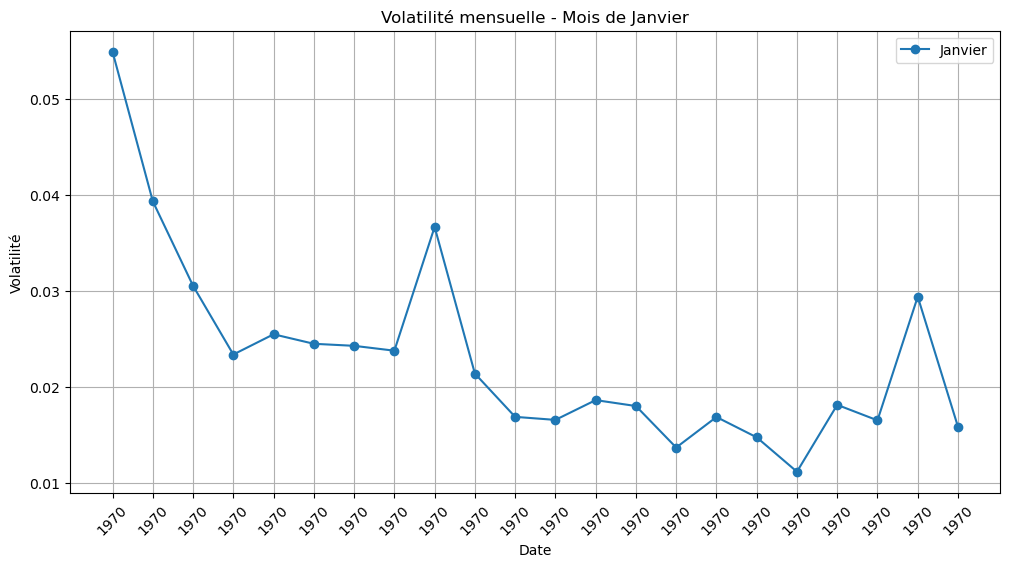

Pas de données disponibles pour les autres mois de l'année.


In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour calculer la volatilité mensuelle
def calcul_volatilite_mensuelle(ticker, debut, fin):
    volatilite = calcul_vol(ticker, debut, fin)
    volatilite.index = pd.to_datetime(volatilite.index)  # Ensure datetime index

    # Filtrer les données pour les mois de janvier
    volatilite_janvier = volatilite[volatilite.index.month == 1]

    # Filtrer les données pour les autres mois de l'année
    volatilite_autres_mois = volatilite[volatilite.index.month != 1]

    return volatilite_janvier, volatilite_autres_mois

# Paramètres
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculer la volatilité mensuelle
volatilite_janvier, volatilite_autres_mois = calcul_volatilite_mensuelle(ticker, debut, fin)

# Tracer la volatilité mensuelle pour les mois de janvier
plt.figure(figsize=(12, 6))
plt.plot(volatilite_janvier.index, volatilite_janvier, marker='o', linestyle='-', label='Janvier')
plt.title('Volatilité mensuelle - Mois de Janvier')
plt.xlabel('Date')
plt.ylabel('Volatilité')
plt.legend()
plt.grid(True)
plt.xticks(volatilite_janvier.index, [str(date.year) for date in volatilite_janvier.index], rotation=45)
plt.show()

# Tracer la volatilité mensuelle pour les autres mois de l'année
if not volatilite_autres_mois.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(volatilite_autres_mois.index, volatilite_autres_mois, marker='o', linestyle='-', label='Autres Mois')
    plt.title('Volatilité mensuelle - Autres Mois')
    plt.xlabel('Date')
    plt.ylabel('Volatilité')
    plt.legend()
    plt.grid(True)
    plt.xticks(volatilite_autres_mois.index, [str(date.year) for date in volatilite_autres_mois.index], rotation=45)
    plt.show()
else:
    print("Pas de données disponibles pour les autres mois de l'année.")


[*********************100%%**********************]  1 of 1 completed


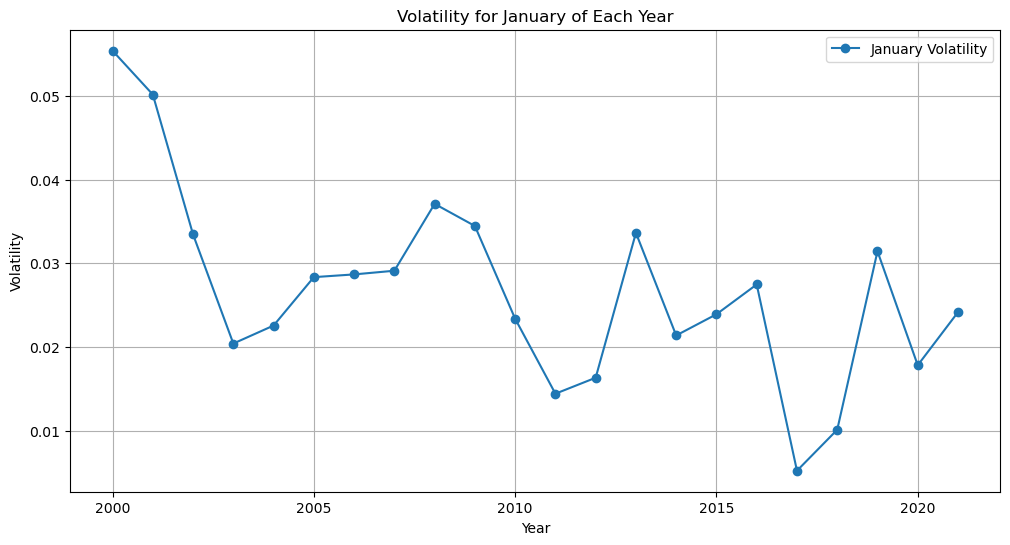

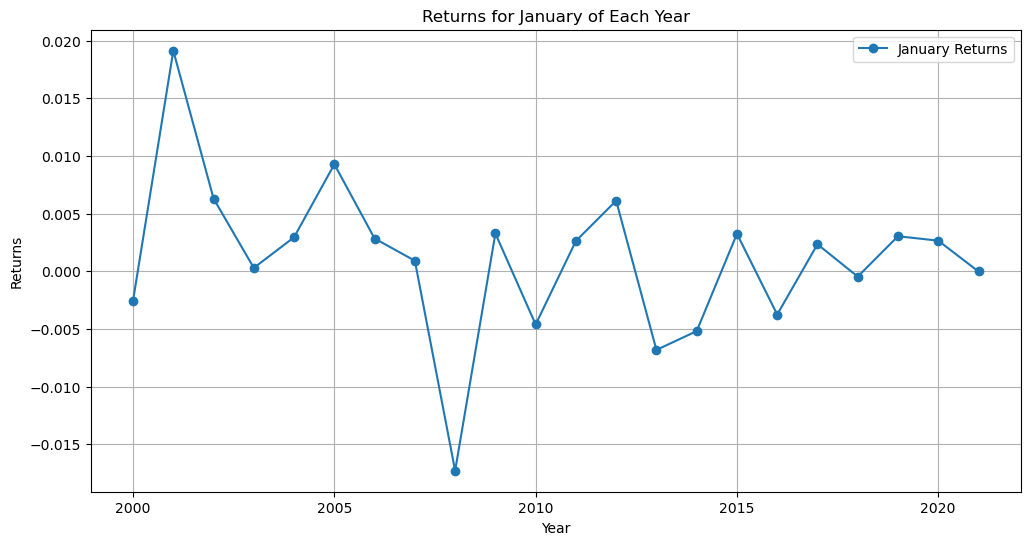

In [67]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Function to calculate daily returns
def calcul_returns(ticker, debut, fin):
    data = yf.download(ticker, start=debut, end=fin, interval="1d")
    returns = data['Close'].pct_change().dropna()
    return returns

# Function to calculate volatility and returns for January of each year
def calculate_january_metrics(ticker, debut, fin):
    # Calculate daily returns
    returns = calcul_returns(ticker, debut, fin)

    # Extract January data for each year
    january_data = returns[returns.index.month == 1]

    # Calculate volatility for January of each year
    january_volatility = january_data.groupby(january_data.index.year).std()

    # Calculate returns for January of each year
    january_returns = january_data.groupby(january_data.index.year).mean()

    return january_volatility, january_returns

# Example usage:
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculate volatility and returns for January of each year
january_volatility, january_returns = calculate_january_metrics(ticker, debut, fin)

# Plot January volatility
plt.figure(figsize=(12, 6))
plt.plot(january_volatility.index, january_volatility, marker='o', linestyle='-', label='January Volatility')
plt.title('Volatility for January of Each Year')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Plot January returns
plt.figure(figsize=(12, 6))
plt.plot(january_returns.index, january_returns, marker='o', linestyle='-', label='January Returns')
plt.title('Returns for January of Each Year')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


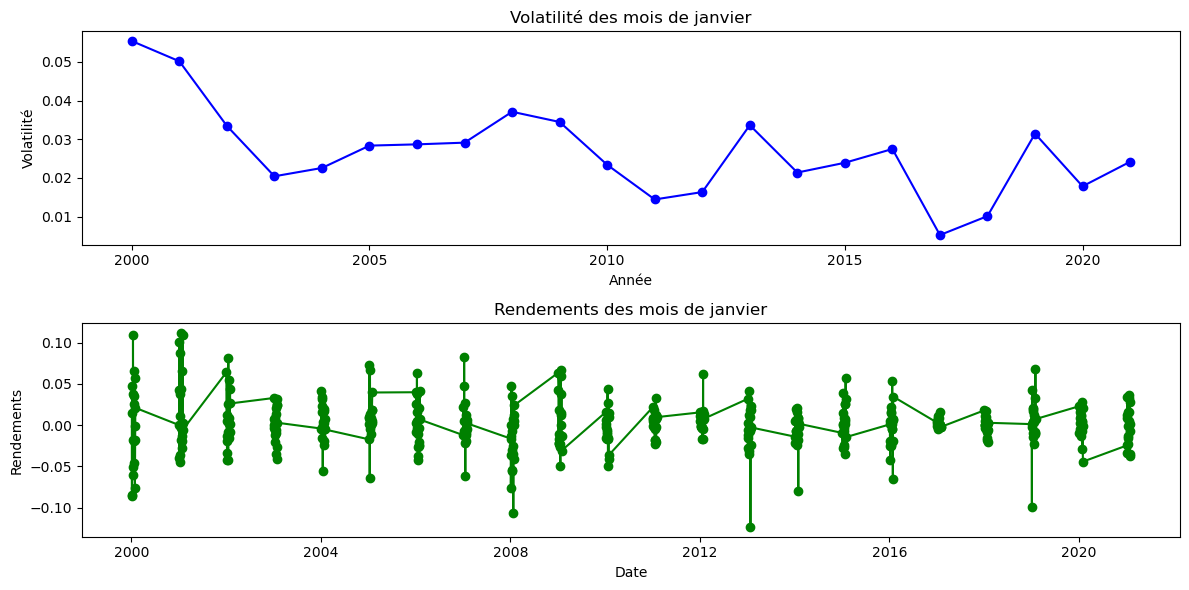

In [68]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer les rendements quotidiens
def calcul_returns(ticker, debut, fin):
    data = yf.download(ticker, start=debut, end=fin, interval="1d")
    returns = data['Close'].pct_change().dropna()
    return returns

# Fonction pour calculer la volatilité mensuelle moyenne
def calcul_volatilite_mensuelle(ticker, debut, fin, mois):
    returns = calcul_returns(ticker, debut, fin)
    returns_mois = returns[returns.index.month == mois]
    volatilite_mensuelle = returns_mois.groupby(returns_mois.index.year).std()
    return volatilite_mensuelle

# Paramètres
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculer la volatilité des mois de janvier
january_volatility = calcul_volatilite_mensuelle(ticker, debut, fin, mois=1)

# Calculer les rendements des mois de janvier
january_returns = calcul_returns(ticker, debut, fin)
january_returns = january_returns[january_returns.index.month == 1]

# Afficher les résultats pour les mois de janvier
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(january_volatility.index, january_volatility, marker='o', linestyle='-', color='blue')
plt.title('Volatilité des mois de janvier')
plt.xlabel('Année')
plt.ylabel('Volatilité')

plt.subplot(2, 1, 2)
plt.plot(january_returns.index, january_returns, marker='o', linestyle='-', color='green')
plt.title('Rendements des mois de janvier')
plt.xlabel('Date')
plt.ylabel('Rendements')

plt.tight_layout()
plt.show()


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate daily returns
def calcul_returns(ticker, debut, fin):
    data = yf.download(ticker, start=debut, end=fin, interval="1d")
    returns = data['Close'].pct_change().dropna()
    return returns

# Function to calculate volatility and returns for January of each year
def calculate_january_metrics(ticker, debut, fin):
    # Calculate daily returns
    returns = calcul_returns(ticker, debut, fin)

    # Extract January data for each year
    january_data = returns[returns.index.month == 1]

    # Calculate volatility for January of each year
    january_volatility = january_data.groupby(january_data.index.year).std()

    # Calculate returns for January of each year
    january_returns = january_data.groupby(january_data.index.year).mean()

    return january_volatility, january_returns

# Example usage:
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculate volatility and returns for January of each year
january_volatility, january_returns = calculate_january_metrics(ticker, debut, fin)

# Plot January volatility
plt.figure(figsize=(12, 6))
plt.plot(january_volatility.index, january_volatility, marker='o', linestyle='-', label='January Volatility')
plt.title('Volatility for January of Each Year')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Plot January returns
plt.figure(figsize=(12, 6))
plt.plot(january_returns.index, january_returns, marker='o', linestyle='-', label='January Returns')
plt.title('Returns for January of Each Year')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

# Fonction pour calculer les rendements quotidiens
def calcul_returns(ticker, debut, fin):
    data = yf.download(ticker, start=debut, end=fin, interval="1d")
    returns = data['Close'].pct_change().dropna()
    return returns

# Fonction pour calculer la volatilité mensuelle moyenne
def calcul_volatilite_mensuelle(ticker, debut, fin, mois):
    returns = calcul_returns(ticker, debut, fin)
    returns_mois = returns[returns.index.month == mois]
    volatilite_mensuelle = returns_mois.groupby(returns_mois.index.year).std()
    return volatilite_mensuelle

# Paramètres
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculer la volatilité des mois de janvier
january_volatility = calcul_volatilite_mensuelle(ticker, debut, fin, mois=1)

# Calculer les rendements des mois de janvier
january_returns = calcul_returns(ticker, debut, fin)
january_returns = january_returns[january_returns.index.month == 1]

# Afficher les résultats pour les mois de janvier
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(january_volatility.index, january_volatility, marker='o', linestyle='-', color='blue')
plt.title('Volatilité des mois de janvier')
plt.xlabel('Année')
plt.ylabel('Volatilité')

plt.subplot(2, 1, 2)
plt.plot(january_returns.index, january_returns, marker='o', linestyle='-', color='green')
plt.title('Rendements des mois de janvier')
plt.xlabel('Date')
plt.ylabel('Rendements')

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


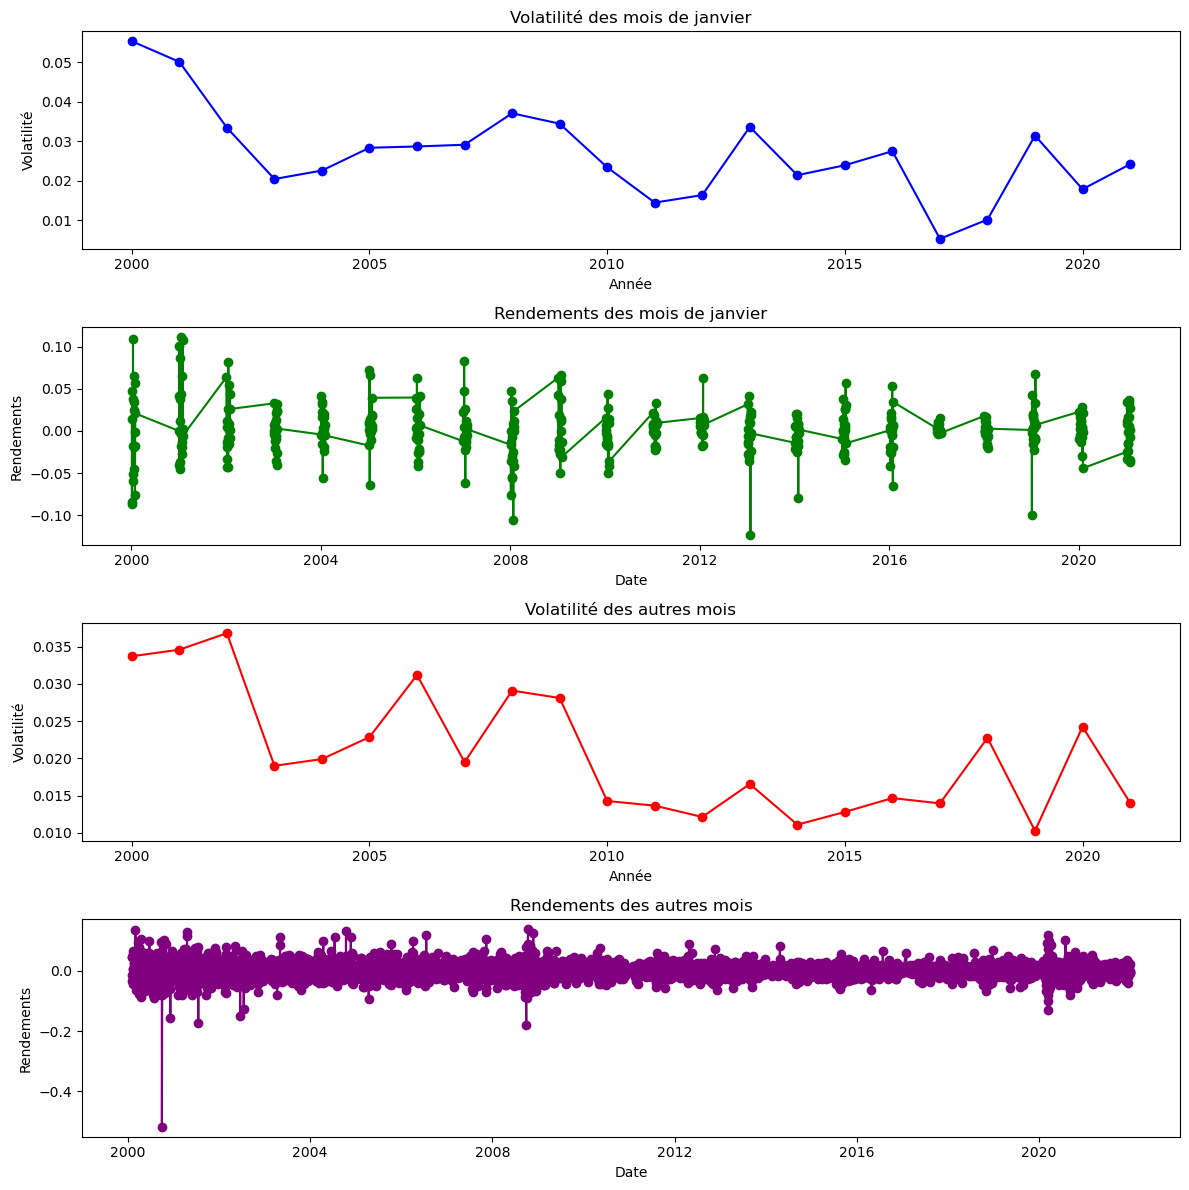

In [69]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer les rendements quotidiens
def calcul_returns(ticker, debut, fin):
    data = yf.download(ticker, start=debut, end=fin, interval="1d")
    returns = data['Close'].pct_change().dropna()
    return returns

# Fonction pour calculer la volatilité mensuelle moyenne
def calcul_volatilite_mensuelle(ticker, debut, fin, mois):
    returns = calcul_returns(ticker, debut, fin)
    returns_mois = returns[returns.index.month == mois]
    volatilite_mensuelle = returns_mois.groupby(returns_mois.index.year).std()
    return volatilite_mensuelle

# Paramètres
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculer la volatilité des mois de janvier
january_volatility = calcul_volatilite_mensuelle(ticker, debut, fin, mois=1)

# Calculer les rendements des mois de janvier
january_returns = calcul_returns(ticker, debut, fin)
january_returns = january_returns[january_returns.index.month == 1]

# Calculer la volatilité des autres mois
other_month_volatility = calcul_volatilite_mensuelle(ticker, debut, fin, mois=2)

# Calculer les rendements des autres mois
other_month_returns = calcul_returns(ticker, debut, fin)
other_month_returns = other_month_returns[other_month_returns.index.month != 1]

# Afficher les résultats
plt.figure(figsize=(12, 12))

# Volatilité de janvier
plt.subplot(4, 1, 1)
plt.plot(january_volatility.index, january_volatility, marker='o', linestyle='-', color='blue')
plt.title('Volatilité des mois de janvier')
plt.xlabel('Année')
plt.ylabel('Volatilité')

# Rendements de janvier
plt.subplot(4, 1, 2)
plt.plot(january_returns.index, january_returns, marker='o', linestyle='-', color='green')
plt.title('Rendements des mois de janvier')
plt.xlabel('Date')
plt.ylabel('Rendements')

# Volatilité des autres mois
plt.subplot(4, 1, 3)
plt.plot(other_month_volatility.index, other_month_volatility, marker='o', linestyle='-', color='red')
plt.title('Volatilité des autres mois')
plt.xlabel('Année')
plt.ylabel('Volatilité')

# Rendements des autres mois
plt.subplot(4, 1, 4)
plt.plot(other_month_returns.index, other_month_returns, marker='o', linestyle='-', color='purple')
plt.title('Rendements des autres mois')
plt.xlabel('Date')
plt.ylabel('Rendements')

plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


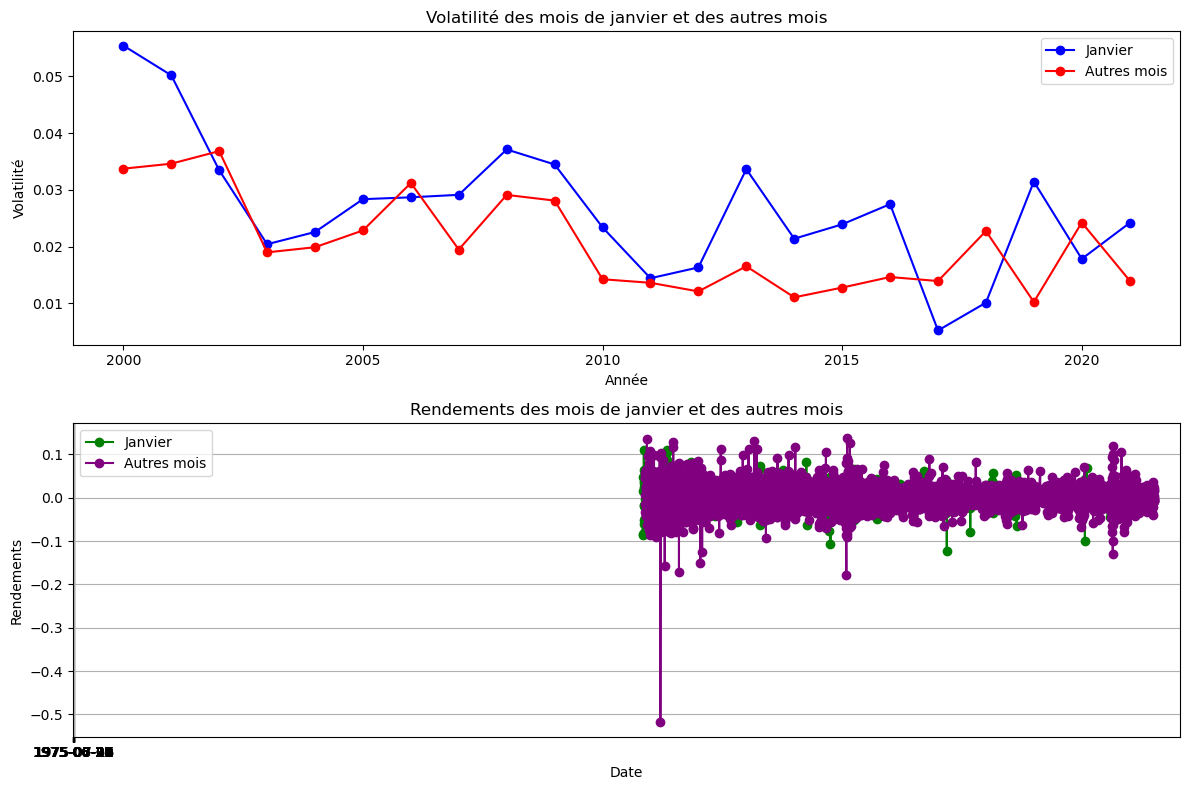

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


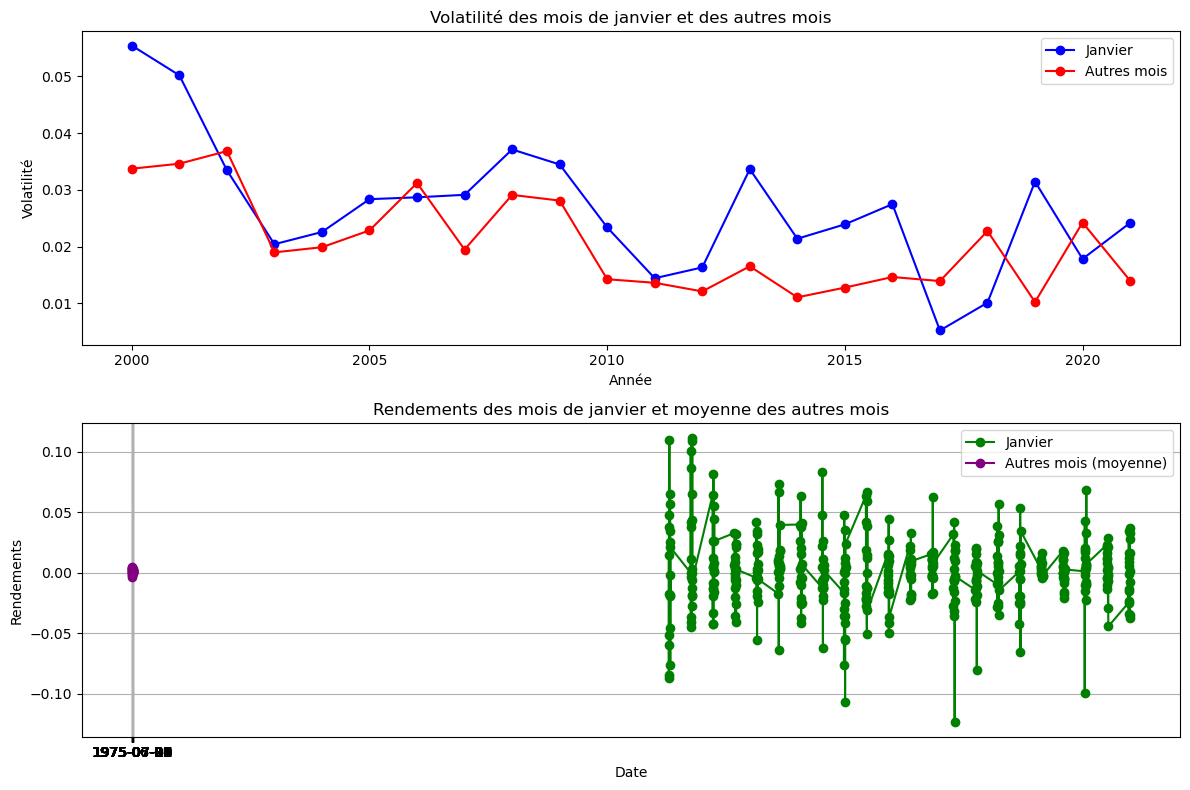

In [73]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer les rendements quotidiens
def calcul_returns(ticker, debut, fin):
    data = yf.download(ticker, start=debut, end=fin, interval="1d")
    returns = data['Close'].pct_change().dropna()
    return returns

# Fonction pour calculer la volatilité mensuelle moyenne
def calcul_volatilite_mensuelle(ticker, debut, fin, mois):
    returns = calcul_returns(ticker, debut, fin)
    returns_mois = returns[returns.index.month == mois]
    volatilite_mensuelle = returns_mois.groupby(returns_mois.index.year).std()
    return volatilite_mensuelle

# Paramètres
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculer la volatilité des mois de janvier
january_volatility = calcul_volatilite_mensuelle(ticker, debut, fin, mois=1)

# Calculer les rendements des mois de janvier
january_returns = calcul_returns(ticker, debut, fin)
january_returns = january_returns[january_returns.index.month == 1]

# Calculer la volatilité des autres mois
other_month_volatility = calcul_volatilite_mensuelle(ticker, debut, fin, mois=2)

# Calculer les rendements des autres mois
other_month_returns = calcul_returns(ticker, debut, fin)
other_month_returns = other_month_returns[other_month_returns.index.month != 1]

# Afficher les résultats
plt.figure(figsize=(12, 8))

# Volatilité
plt.subplot(2, 1, 1)
plt.plot(january_volatility.index, january_volatility, marker='o', linestyle='-', color='blue', label='Janvier')
plt.plot(other_month_volatility.index, other_month_volatility, marker='o', linestyle='-', color='red', label='Autres mois')
plt.title('Volatilité des mois de janvier et des autres mois')
plt.xlabel('Année')
plt.ylabel('Volatilité')
plt.legend()

# Rendements moyens des autres mois pour chaque année
other_month_returns_mean = other_month_returns.groupby(other_month_returns.index.year).mean()

# Rendements
plt.subplot(2, 1, 2)
plt.plot(january_returns.index, january_returns, marker='o', linestyle='-', color='green', label='Janvier')
plt.plot(other_month_returns_mean.index, other_month_returns_mean, marker='o', linestyle='-', color='purple', label='Autres mois (moyenne)')
plt.title('Rendements des mois de janvier et moyenne des autres mois')
plt.xlabel('Date')
plt.ylabel('Rendements')
plt.legend()
plt.grid(True)  # Ajouter une grille

# Formater l'axe des x pour afficher les années de manière lisible
plt.xticks(np.arange(min(january_returns.index.year), max(january_returns.index.year)+1, 1.0))

plt.tight_layout()
plt.show()


In [74]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer les rendements quotidiens
def calculate_returns(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, interval="1d")
    returns = data['Close'].pct_change().dropna()
    return returns

# Fonction pour calculer la volatilité mensuelle
def calcul_volatilite_mensuelle(ticker, debut, fin):
    volatilite = calcul_vol(ticker, debut, fin)
    volatilite.index = pd.to_datetime(volatilite.index)  # Ensure datetime index

    # Filtrer les données pour les mois de janvier
    volatilite_janvier = volatilite[volatilite.index.month == 1]

    # Filtrer les données pour les autres mois de l'année
    volatilite_autres_mois = volatilite[volatilite.index.month != 1]

    return volatilite_janvier, volatilite_autres_mois

# Fonction pour calculer les rendements de janvier pour chaque année
def calculate_january_returns(ticker, start, end):
    returns = calculate_returns(ticker, start, end)

    # Rendements de janvier pour chaque année
    january_returns_by_year = returns[returns.index.month == 1].groupby(returns.index.year).mean()

    return january_returns_by_year

# Fonction pour calculer les rendements moyens des autres mois pour chaque année
def calculate_other_month_returns_mean(ticker, start, end):
    returns = calculate_returns(ticker, start, end)

    # Rendements des autres mois
    other_month_returns = returns[returns.index.month != 1]

    # Rendements moyens des autres mois pour chaque année
    other_month_returns_mean_by_year = other_month_returns.groupby(other_month_returns.index.year).mean()

    return other_month_returns_mean_by_year

# Paramètres
ticker = "AAPL"
start_date = "2000-01-01"
end_date = "2022-01-01"

# Calcul des rendements de janvier pour chaque année
january_returns_by_year = calculate_january_returns(ticker, start_date, end_date)

# Affichage des rendements de janvier pour chaque année
plt.figure(figsize=(12, 6))
plt.plot(january_returns_by_year.index, january_returns_by_year, marker='o', linestyle='-', color='green')
plt.title('Rendements de janvier pour chaque année')
plt.xlabel('Année')
plt.ylabel('Rendements')
plt.grid(True)  # Ajouter une grille
plt.show()

# Calcul des rendements moyens des autres mois pour chaque année
other_month_returns_mean_by_year = calculate_other_month_returns_mean(ticker, start_date, end_date)

# Affichage des rendements moyens des autres mois pour chaque année
plt.figure(figsize=(12, 6))
plt.plot(other_month_returns_mean_by_year.index, other_month_returns_mean_by_year, marker='o', linestyle='-', color='purple')
plt.title('Rendements moyens des autres mois pour chaque année')
plt.xlabel('Année')
plt.ylabel('Rendements moyens')
plt.grid(True)  # Ajouter une grille
plt.show()


[*********************100%%**********************]  1 of 1 completed


ValueError: Grouper and axis must be same length

In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer les rendements quotidiens
def calculate_returns(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, interval="1d")
    returns = data['Close'].pct_change().dropna()
    return returns

# Fonction pour calculer la volatilité mensuelle
def calcul_volatilite_mensuelle(ticker, debut, fin):
    volatilite = calcul_vol(ticker, debut, fin)
    volatilite.index = pd.to_datetime(volatilite.index)  # Ensure datetime index

    # Filtrer les données pour les mois de janvier
    volatilite_janvier = volatilite[volatilite.index.month == 1]

    # Filtrer les données pour les autres mois de l'année
    volatilite_autres_mois = volatilite[volatilite.index.month != 1]

    return volatilite_janvier, volatilite_autres_mois
# Fonction pour calculer les rendements de janvier pour chaque année
def calculate_january_returns(ticker, start, end):
    returns = calculate_returns(ticker, start, end)

    # Ajouter une colonne "Month" aux données en incluant également la date de fin du mois de janvier
    returns['Month'] = returns.index.to_period('M').astype(str)

    # Rendements de janvier pour chaque année
    january_returns_by_year = returns[returns['Month'] == '2000-01'].groupby(returns.index.year)['Close'].mean()

    return january_returns_by_year

# Fonction pour calculer les rendements moyens des autres mois pour chaque année
def calculate_other_month_returns_mean(ticker, start, end):
    returns = calculate_returns(ticker, start, end)

    # Ajouter une colonne "Month" aux données
    returns['Month'] = returns.index.month

    # Rendements des autres mois
    other_month_returns = returns[returns['Month'] != 1]

    # Rendements moyens des autres mois pour chaque année
    other_month_returns_mean_by_year = other_month_returns.groupby(returns.index.year)['Close'].mean()

    return other_month_returns_mean_by_year

# Paramètres
ticker = "AAPL"
start_date = "2000-01-01"
end_date = "2022-01-01"

# Calcul des rendements de janvier pour chaque année
january_returns_by_year = calculate_january_returns(ticker, start_date, end_date)

# Affichage des rendements de janvier pour chaque année
plt.figure(figsize=(12, 6))
plt.plot(january_returns_by_year.index, january_returns_by_year, marker='o', linestyle='-', color='green')
plt.title('Rendements de janvier pour chaque année')
plt.xlabel('Année')
plt.ylabel('Rendements')
plt.grid(True)  # Ajouter une grille
plt.show()

# Calcul des rendements moyens des autres mois pour chaque année
other_month_returns_mean_by_year = calculate_other_month_returns_mean(ticker, start_date, end_date)

# Affichage des rendements moyens des autres mois pour chaque année
plt.figure(figsize=(12, 6))
plt.plot(other_month_returns_mean_by_year.index, other_month_returns_mean_by_year, marker='o', linestyle='-', color='purple')
plt.title('Rendements moyens des autres mois pour chaque année')
plt.xlabel('Année')
plt.ylabel('Rendements moyens')
plt.grid(True)  # Ajouter une grille
plt.show()


[*********************100%%**********************]  1 of 1 completed


IndexError: Boolean index has wrong length: 5535 instead of 5536